In [1]:
# coding: utf-8
from keras.datasets import mnist
from keras import Model
from keras.layers import Input, Dense, Flatten, Reshape, Lambda
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import CSVLogger
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils import generate_numvec
from vae_loss import vae_loss

/Users/Atsuki/.pyenv/versions/3.6.2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## CVAEのモデル定義部

In [2]:
class Cond_VAE(object):
    def __init__(self, x_shape, y_shape, latent_dim, intermediate_dim_en, intermediate_dim_de, epsilon_std, batch_size):
        self.input_shape = x_shape
        self.category_shape = y_shape
        self.latent_dim = latent_dim
        self.intermediate_dim_en = intermediate_dim_en
        self.intermediate_dim_de = intermediate_dim_de
        self.epsilon_std = epsilon_std
        self.batch_size = batch_size
    
    def vae_model(self):
        # encoder: q(z|x, c)
        x = Input(shape=(self.input_shape[1],))
        cond = Input(shape=(self.category_shape[1],))
        inputs = concatenate([x, cond])
        hidden = Dense(self.intermediate_dim_en, activation='relu')(inputs)
        z_mean = Dense(self.latent_dim, activation='linear')(hidden)
        z_sigma = Dense(self.latent_dim, activation='linear')(hidden)

        # decoder: p(x|z, c)
        z = Lambda(self.sampling, output_shape=(self.latent_dim,))([z_mean, z_sigma])
        z_cond = concatenate([z, cond])
        dense = Dense(self.intermediate_dim_de, activation='relu')(z_cond)
        x_decoded_mean = Dense(self.input_shape[1], activation='sigmoid')(dense)
        y = vae_loss()([x, x_decoded_mean, z_mean, z_sigma])
        return Model([x, cond], y), Model([x, cond], z_mean)

    # サンプル生成用デコーダ
    def generator(self, _model):
        _, _, dense, x_decoded_mean, _ = _model.layers[6:]
        
        decoder_input = Input(shape=(self.latent_dim + self.category_shape[1],))
        _dense = dense(decoder_input)
        _x_decoded_mean = x_decoded_mean(_dense)

        return Model(decoder_input, _x_decoded_mean)

    def sampling(self, args):
        z_mean, z_sigma = args
        epsilon = K.random_normal(shape=(self.batch_size, self.latent_dim), mean=0.,
                              stddev=self.epsilon_std)
        return z_mean + K.exp(z_sigma / 2) * epsilon

    def model_compile(self, model):
        model.compile(optimizer=Adam(lr=0.001), loss=None)

## 定数・ハイパーパラメータとデータセットの定義

In [3]:
if __name__ == '__main__':
    # 定数・ハイパーパラメータ
    batch_size = 250
    latent_dim = 2
    intermediate_dim_en = 512
    intermediate_dim_de = 512
    epochs = 50
    epsilon_std = 1.0

    # データセットを呼び出し
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # ピクセル数を計算
    nb_pixel = np.prod(x_train.shape[1:])
    # 正規化する
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    # concat用にベクトルの変換をする
    x_train = x_train.reshape((len(x_train), nb_pixel))
    x_test = x_test.reshape((len(x_test), nb_pixel))
    # one-hot encoding
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    # check
    print('x_test shape: {0}'.format(x_test.shape))
    print('x_train shape: {0}'.format(x_train.shape))
    print('y_test shape: {0}'.format(y_test.shape))
    print('y_train shape: {0}'.format(y_train.shape))

x_test shape: (10000, 784)
x_train shape: (60000, 784)
y_test shape: (10000, 10)
y_train shape: (60000, 10)


In [4]:
    # VAEクラスからインスタンスを生成
    _vae = Cond_VAE(x_train.shape, y_train.shape, latent_dim, intermediate_dim_en, intermediate_dim_de, epsilon_std, batch_size)

    # save history to CSV
    callbacks = []
    callbacks.append(CSVLogger("history.csv"))

    # build -> compile -> summary -> fit
    _model, _encoder = _vae.vae_model()
    _vae.model_compile(_model)
    _model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          407040      concatenate_1[0][0]              
__________

/Users/Atsuki/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Output "vae_loss_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "vae_loss_1" during training.


In [5]:
    _hist = _model.fit([x_train, y_train],
        verbose=1,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test, y_test], None),
        callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 194us/step - loss: 199.5104 - val_loss: 160.0742
Epoch 2/50
60000/60000 [==============================] - 12s 193us/step - loss: 151.2003 - val_loss: 145.6302
Epoch 3/50
60000/60000 [==============================] - 12s 201us/step - loss: 143.9020 - val_loss: 142.1485
Epoch 4/50
60000/60000 [==============================] - 12s 207us/step - loss: 141.4254 - val_loss: 140.3869
Epoch 5/50
60000/60000 [==============================] - 15s 251us/step - loss: 139.9486 - val_loss: 139.2955
Epoch 6/50
60000/60000 [==============================] - 16s 258us/step - loss: 138.9104 - val_loss: 138.4798
Epoch 7/50
60000/60000 [==============================] - 10s 163us/step - loss: 138.1640 - val_loss: 137.7972
Epoch 8/50
60000/60000 [==============================] - 9s 157us/step - loss: 137.5335 - val_loss: 137.2964
Epoch 9/50
60000/60000 [==============================] - 14s 2

In [6]:
    # save weights
    fpath = 'conv_vae_mnist_weights_' + str(epochs) + '.h5'
    _model.save_weights(fpath)

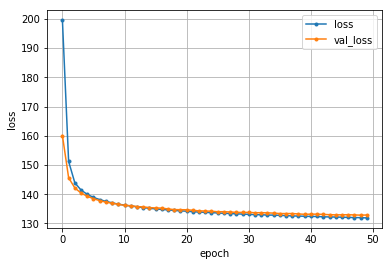

In [7]:
    # plot loss
    loss = _hist.history['loss']
    val_loss = _hist.history['val_loss']
    
    plt.plot(range(0, epochs), loss[0:], marker='.', label='loss')
    plt.plot(range(0, epochs), val_loss[0:], marker='.', label='val_loss')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

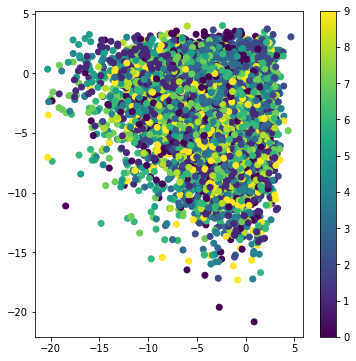

In [8]:
    # 散布図を描画するメソッド: scatter(データx, y, 色c)
    # show q(z|x, y) ~ p(z|y)
    x_test_encoded = _encoder.predict([x_test, y_test], batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = np.argmax(y_test, axis=1))
    plt.colorbar()
    plt.show()

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


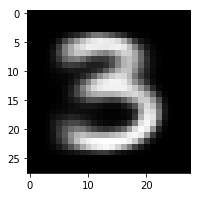

In [9]:
    # 1つプロットしてみる
    sample = generate_numvec(3)
    print(sample)
    _generator = _vae.generator(_model)
    plt.figure(figsize=(3, 3))
    plt.imshow(_generator.predict(sample).reshape(28,28), cmap='gray')
    plt.show()

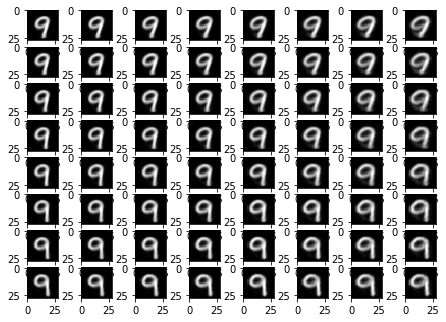

In [10]:
    dig = 9
    sides = 8
    max_z = 1.5

    img_it = 0
    for i in range(0, sides):
        z1 = (((i / (sides-1)) * max_z)*2) - max_z
        for j in range(0, sides):
            z2 = (((j / (sides-1)) * max_z)*2) - max_z
            z_ = [z1, z2]
            vec = generate_numvec(dig, z_)
            decoded = _generator.predict(vec)
            
            plt.subplot(sides, sides, 1 + img_it)
            img_it +=1
            plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
    plt.show()

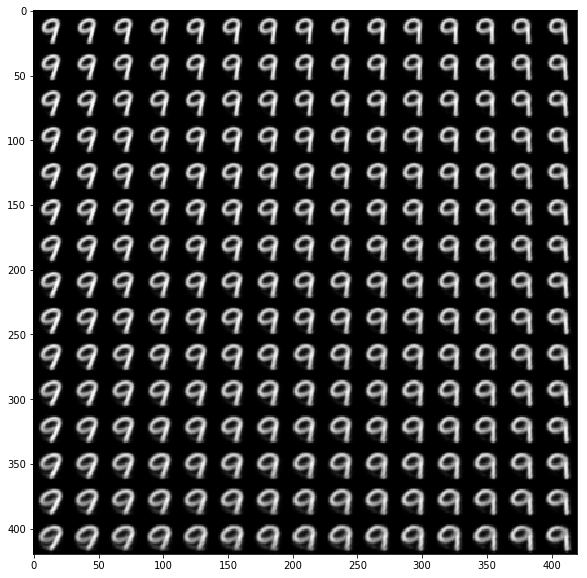

In [11]:
    # show p(x|z, y)
    n = 15
    dig = 9  
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    _generator = _vae.generator(_model)
    
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([xi, yi])
            vec = generate_numvec(dig, z_sample)
            x_decoded = _generator.predict(vec)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure,cmap='gray')
    plt.show()